In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as LA

In [2]:
# Generate data 
n = 20 # Number of functions
xi = 2 # Vary the condition number
d = 500 # Dimension
A = []
[L, mu] = [1e-10, 1e10]
b = np.zeros((n, d))
for i in range(n):
    a = np.zeros(d)
    # Sample the first d / 2 elements from [1, 10 ** (xi/2)]
    a[0: int(d / 2)] = np.random.uniform(1, 10 ** (0.5 * xi), size = int(d / 2))
    
    # Sample the next d / 2 elements from [10 ** (-xi/2), 1]
    a[int(d / 2): d] = np.random.uniform(10 ** (-0.5 * xi), 1, size = int(d / 2))
    L = max(L, np.max(a))
    mu = min(mu, np.min(a))
    A.append(np.diag(a))
    
    # b_i is generated by sampling from the box [0, 1000] ^ {d}
    b[i] = np.random.uniform(0, 1000, d)
    
sum_A = sum(A)
sum_b = np.sum(b, axis = 0)

In [3]:
L, mu

(9.999120992263538, 0.10009583382974388)

In [4]:
epochs = 100
gstop = 1e-7

In [5]:
x_0 = 0.1 * np.random.rand(d)
B_approx = np.zeros((d, d, n))
for i in range(n):
#     B_approx[:, :, i] = 10 ** (0.75 * xi) * np.identity(d)
      B_approx[:, :, i] = L * np.identity(d)
sum_B_inverse = LA.inv(np.sum(B_approx, 2))

all_z_vals = np.zeros((n, d))
for i in range(n):
    all_z_vals[i] = np.copy(x_0)


all_gradients = np.zeros((n, d))
for i in range(n):
    all_gradients[i] = (A[i] @ x_0) + b[i]
sum_gradients = np.sum(all_gradients, axis = 0)

all_Bz_vals = np.zeros((n, d))
for i in range(n):
    all_Bz_vals[i] = B_approx[:, :, i] @ x_0
sum_Bz_vals = np.sum(all_Bz_vals, axis = 0)

initial_gradient_norm = LA.norm(sum_A @ x_0 + sum_b) / n
print("Initial gradient norm : {}".format(initial_gradient_norm))

Initial gradient norm : 11283.800852295795


In [6]:
def find_minima(B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g):
    global x_star
    x_star = np.zeros(d)
    global conv_iters
    conv_iters = 1
    print("Started IQN!")
    x = np.copy(x_0)
    for t in range(epochs):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            curr_grad_i = (A[i] @ x + b[i]) # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation

            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B[:, :, i] = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)

            # Update Binv in O(d ^ 2) time
            Binv_y = sum_B_inv @ y
            Z = sum_B_inv - np.outer(Binv_y, Binv_y.T) / (np.dot(s, y) + np.dot(y, Binv_y))
            ZBs = Z @ Bs
            sum_B_inv = Z + np.outer(ZBs, ZBs.T) / (np.dot(s, Bs) - np.dot(Bs, ZBs))
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B[:, :, i] @ x) - all_Bz[i]

            # Maintain the old variables
            all_Bz[i] = B[:, :, i] @ x
            all_z[i] = x
            all_g[i] = curr_grad_i
    
        gnorm = LA.norm(sum_A @ x + sum_b) / n
        if gnorm < gstop:
            print("Found minima after t : {} epochs".format(t))
            x_star = x
            conv_iters = t
            break
        print("(IQN) Current epoch : {} Current gnorm : {}".format(t, gnorm))
        
find_minima(np.copy(B_approx), np.copy(sum_B_inverse), 
    np.copy(all_z_vals), np.copy(all_Bz_vals), 
    np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients))

Started IQN!
(IQN) Current epoch : 0 Current gnorm : 7138.88102065454
(IQN) Current epoch : 1 Current gnorm : 7722.581123995065
(IQN) Current epoch : 2 Current gnorm : 1863.7121408907424
(IQN) Current epoch : 3 Current gnorm : 574.9322604143488
(IQN) Current epoch : 4 Current gnorm : 500.9030437518143
(IQN) Current epoch : 5 Current gnorm : 474.4033060238679
(IQN) Current epoch : 6 Current gnorm : 200.08992683747834
(IQN) Current epoch : 7 Current gnorm : 70.55579360217389
(IQN) Current epoch : 8 Current gnorm : 59.798605202227144
(IQN) Current epoch : 9 Current gnorm : 59.959086276656365
(IQN) Current epoch : 10 Current gnorm : 27.880355851144223
(IQN) Current epoch : 11 Current gnorm : 10.56047022501837
(IQN) Current epoch : 12 Current gnorm : 9.031069305088415
(IQN) Current epoch : 13 Current gnorm : 9.060601839785583
(IQN) Current epoch : 14 Current gnorm : 3.917870234876921
(IQN) Current epoch : 15 Current gnorm : 1.5423508584343948
(IQN) Current epoch : 16 Current gnorm : 1.34531

In [7]:
conv_iters

46

In [8]:
def IQN(B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g):
    y_axis_iqn = np.zeros(conv_iters)
    print("Started IQN!")
    x = np.copy(x_0)
    for t in range(conv_iters):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            curr_grad_i = (A[i] @ x + b[i]) # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation

            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B[:, :, i] = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)

            # Update Binv in O(d ^ 2) time
            Binv_y = sum_B_inv @ y
            Z = sum_B_inv - np.outer(Binv_y, Binv_y.T) / (np.dot(s, y) + np.dot(y, Binv_y))
            ZBs = Z @ Bs
            sum_B_inv = Z + np.outer(ZBs, ZBs.T) / (np.dot(s, Bs) - np.dot(Bs, ZBs))
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B[:, :, i] @ x) - all_Bz[i]

            # Maintain the old variables
            all_Bz[i] = B[:, :, i] @ x
            all_z[i] = x
            all_g[i] = curr_grad_i
        
        gnorm = LA.norm(sum_A @ x + sum_b) / n 
        y_axis_iqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        print("(IQN) Current epoch : {} Current gradient norm : {}".format(t, gnorm))
        
    return y_axis_iqn
y_axis_iqn = IQN(np.copy(B_approx), np.copy(sum_B_inverse), 
    np.copy(all_z_vals), np.copy(all_Bz_vals), 
    np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients))

Started IQN!
(IQN) Current epoch : 0 Current gradient norm : 7138.88102065454
(IQN) Current epoch : 1 Current gradient norm : 7722.581123995065
(IQN) Current epoch : 2 Current gradient norm : 1863.7121408907424
(IQN) Current epoch : 3 Current gradient norm : 574.9322604143488
(IQN) Current epoch : 4 Current gradient norm : 500.9030437518143
(IQN) Current epoch : 5 Current gradient norm : 474.4033060238679
(IQN) Current epoch : 6 Current gradient norm : 200.08992683747834
(IQN) Current epoch : 7 Current gradient norm : 70.55579360217389
(IQN) Current epoch : 8 Current gradient norm : 59.798605202227144
(IQN) Current epoch : 9 Current gradient norm : 59.959086276656365
(IQN) Current epoch : 10 Current gradient norm : 27.880355851144223
(IQN) Current epoch : 11 Current gradient norm : 10.56047022501837
(IQN) Current epoch : 12 Current gradient norm : 9.031069305088415
(IQN) Current epoch : 13 Current gradient norm : 9.060601839785583
(IQN) Current epoch : 14 Current gradient norm : 3.9178

In [9]:
def Greedy_IQN(B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g, args):
    sum_B = LA.inv(sum_B_inv)
    print("Started Greedy IQN!")
    y_axis_giqn = np.zeros(conv_iters)
    x = np.copy(x_0)
    M = 0 # tune this to change the convergence rate
    for t in range(conv_iters):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            r = np.sqrt(np.dot(s, A[i] @ s)) # compute r = sqrt(s^T * Actual Hessian * s)
            
            curr_grad_i = A[i] @ x + b[i] # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation
            
            B_upon_A = np.diagonal(B_i) / np.diagonal(A[i])
            max_idx = np.argmax(B_upon_A)
            greedy_vec = np.zeros(d)
            greedy_vec[max_idx] = 1
            actual_hess_col = A[i][max_idx]
            
            Q = (1 + M * r) * B_i
            Qu = Q[max_idx] # Q @ u
            B_i = Q - np.outer(Qu, Qu.T) / Qu[max_idx] + np.outer(actual_hess_col, actual_hess_col.T) / actual_hess_col[max_idx]

            
            if args == 0:
                psi2_inv_Qu = sum_B_inv @ Qu
                psi1_inv = sum_B_inv + np.outer(psi2_inv_Qu, psi2_inv_Qu.T) / (
                            Qu[max_idx] - np.dot(Qu, psi2_inv_Qu))

                psi1_inv_hessu = psi1_inv @ actual_hess_col
                sum_B_inv = psi1_inv - np.outer(psi1_inv_hessu, psi1_inv_hessu.T) / (
                            actual_hess_col[max_idx] + np.dot(actual_hess_col, psi1_inv_hessu))
                
            else:
                sum_B = sum_B + B_i - B[:, :, i]
                sum_B_inv = LA.inv(sum_B)
            
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B_i @ x) - all_Bz[i]

            # Maintain the old variables
            B[:, :, i] = B_i
            all_Bz[i] = B_i @ x
            all_z[i] = np.copy(x)
            all_g[i] = curr_grad_i
            
        y_axis_giqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        gnorm = LA.norm(sum_A @ x + sum_b) / n  
        print("(IGS) Current epoch : {} Current gradient norm : {}".format(t, gnorm))
        
    return y_axis_giqn
y_axis_giqn = Greedy_IQN(np.copy(B_approx), np.copy(sum_B_inverse), 
    np.copy(all_z_vals), np.copy(all_Bz_vals), 
    np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients), 1)

Started Greedy IQN!
(IGS) Current epoch : 0 Current gradient norm : 7083.694726577404
(IGS) Current epoch : 1 Current gradient norm : 6269.005224251724
(IGS) Current epoch : 2 Current gradient norm : 5625.402301491589
(IGS) Current epoch : 3 Current gradient norm : 5052.844125144295
(IGS) Current epoch : 4 Current gradient norm : 4538.286481812683
(IGS) Current epoch : 5 Current gradient norm : 4075.3895743776557
(IGS) Current epoch : 6 Current gradient norm : 3658.962641946639
(IGS) Current epoch : 7 Current gradient norm : 3284.3018974950596
(IGS) Current epoch : 8 Current gradient norm : 2947.26455417203
(IGS) Current epoch : 9 Current gradient norm : 2644.166909107267
(IGS) Current epoch : 10 Current gradient norm : 2371.7409735345036
(IGS) Current epoch : 11 Current gradient norm : 2126.8633112852644
(IGS) Current epoch : 12 Current gradient norm : 1906.9780193803206
(IGS) Current epoch : 13 Current gradient norm : 1709.4118473779836
(IGS) Current epoch : 14 Current gradient norm 

In [10]:
def Hybrid_IQN(B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g, args):
    sum_B = LA.inv(sum_B_inv)
    print("Started Hybrid IQN!")
    x = np.copy(x_0)
    y_axis_hiqn = np.zeros(conv_iters) 
    M = 0 # tune this to change the convergence rate
    for t in range(conv_iters):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            r = np.sqrt(np.dot(s, A[i] @ s)) # compute r = sqrt(s^T * Actual Hessian * s)
            
            curr_grad_i = A[i] @ x + b[i] # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation
            
            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B_intermediate = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)
            
            
            B_upon_A = np.diagonal(B_intermediate) / np.diagonal(A[i])
            max_idx = np.argmax(B_upon_A)
            greedy_vec = np.zeros(d)
            greedy_vec[max_idx] = 1
            actual_hess_col = A[i][max_idx]
            
            Q = ((1 + 0.5 * M * r) ** 2) * B_intermediate
            Qu = Q[max_idx] # Q @ u
            B_final = Q - np.outer(Qu, Qu.T) / Qu[max_idx] + np.outer(actual_hess_col, actual_hess_col.T) / actual_hess_col[max_idx]

            
            if args == 0:
                # The following updates are meant to update sum_B_inv in O(d ^ 2) time
                # Since M = 0, sum_B_inv = inv(sum D_i(t - 1)) (in the draft)
                sum_B_inv_y = sum_B_inv @ y
                psi3_inv = sum_B_inv - np.outer(sum_B_inv_y, sum_B_inv_y.T) / (
                    np.dot(y, s) + np.dot(y, sum_B_inv_y))

                psi3_inv_Bs = psi3_inv @ Bs
                psi2_inv = psi3_inv + np.outer(psi3_inv_Bs, psi3_inv_Bs.T) / (
                            np.dot(s, Bs) - np.dot(Bs, psi3_inv_Bs))

                psi2_inv_Qu = psi2_inv @ Qu
                psi1_inv = psi2_inv + np.outer(psi2_inv_Qu, psi2_inv_Qu.T) / (
                            Qu[max_idx] - np.dot(Qu, psi2_inv_Qu))

                psi1_inv_hessu = psi1_inv @ actual_hess_col
                sum_B_inv = psi1_inv - np.outer(psi1_inv_hessu, psi1_inv_hessu.T) / (
                            actual_hess_col[max_idx] + np.dot(actual_hess_col, psi1_inv_hessu))
            
            else:
                sum_B = sum_B + B_final - B[:, :, i]
                sum_B_inv = LA.inv(sum_B)
            
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B_final @ x) - all_Bz[i]

            # Maintain the old variables
            B[:, :, i] = B_final
            all_Bz[i] = B_final @ x
            all_z[i] = np.copy(x)
            all_g[i] = curr_grad_i
        
        y_axis_hiqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        gnorm = LA.norm(sum_A @ x + sum_b) / n  
        print("(SLIQN) Current epoch : {} Current gradient norm : {}".format(t, gnorm))

    return y_axis_hiqn

y_axis_hiqn = Hybrid_IQN(np.copy(B_approx), np.copy(sum_B_inverse), 
    np.copy(all_z_vals), np.copy(all_Bz_vals), 
    np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients), 0)

Started Hybrid IQN!
(SLIQN) Current epoch : 0 Current gradient norm : 7136.710636150941
(SLIQN) Current epoch : 1 Current gradient norm : 7713.153669877832
(SLIQN) Current epoch : 2 Current gradient norm : 1856.5327624505305
(SLIQN) Current epoch : 3 Current gradient norm : 571.8736437571569
(SLIQN) Current epoch : 4 Current gradient norm : 497.75648444269245
(SLIQN) Current epoch : 5 Current gradient norm : 466.2468729801
(SLIQN) Current epoch : 6 Current gradient norm : 192.25216670818307
(SLIQN) Current epoch : 7 Current gradient norm : 64.36993863602359
(SLIQN) Current epoch : 8 Current gradient norm : 52.79900671503774
(SLIQN) Current epoch : 9 Current gradient norm : 51.89057236742765
(SLIQN) Current epoch : 10 Current gradient norm : 23.241890431365366
(SLIQN) Current epoch : 11 Current gradient norm : 7.263008463045476
(SLIQN) Current epoch : 12 Current gradient norm : 5.449758682969402
(SLIQN) Current epoch : 13 Current gradient norm : 5.466019321287524
(SLIQN) Current epoch :

In [11]:
def Sharpened_BFGS():
    print("Started Sharpened BFGS!")
    x = np.copy(x_0)
    B = L * np.identity(d)
    M_sharp_bfgs = 0
    y_axis_sharpened_BFGS = np.zeros(3 * conv_iters)
    for t in range(3 * conv_iters):
        oldx = np.copy(x)
        oldgrad = (sum_A @ x) / n + (sum_b / n)
        x = x - 1 * LA.inv(B) @ oldgrad
        
        newgrad = (sum_A @ x + sum_b) / n
        
        s = x - oldx
        y = newgrad - oldgrad
        
        Bs = B @ s
        B = B + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)
        
        r = np.sqrt(np.dot(s, (sum_A / n) @ s))
       
        
        B_upon_A = np.diagonal(B) / np.diagonal(sum_A)
        max_idx = np.argmax(B_upon_A)
        greedy_vec = np.zeros(d)
        greedy_vec[max_idx] = 1
        actual_hess_col = (sum_A / n)[max_idx]
        
    
        Q = ((1 + 0.5 * M_sharp_bfgs * r) ** 2) * B
        Qu = Q[max_idx] # Q @ u
        B = Q - np.outer(Qu, Qu.T) / Qu[max_idx] + np.outer(actual_hess_col, actual_hess_col.T) / actual_hess_col[max_idx]
        
        y_axis_sharpened_BFGS[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        print("(Sharpened BFGS) Current epoch : {} Current gradient norm : {}".format(t, LA.norm(newgrad)))
        
        
    return y_axis_sharpened_BFGS
        
y_axis_sharpened_BFGS = Sharpened_BFGS()

Started Sharpened BFGS!
(Sharpened BFGS) Current epoch : 0 Current gradient norm : 8367.489422026802
(Sharpened BFGS) Current epoch : 1 Current gradient norm : 8377.49143740093
(Sharpened BFGS) Current epoch : 2 Current gradient norm : 9177.213828879861
(Sharpened BFGS) Current epoch : 3 Current gradient norm : 7413.954223321785
(Sharpened BFGS) Current epoch : 4 Current gradient norm : 3427.702641513902
(Sharpened BFGS) Current epoch : 5 Current gradient norm : 898.7668161031543
(Sharpened BFGS) Current epoch : 6 Current gradient norm : 543.5612500284572
(Sharpened BFGS) Current epoch : 7 Current gradient norm : 452.00333890222703
(Sharpened BFGS) Current epoch : 8 Current gradient norm : 418.28732469830805
(Sharpened BFGS) Current epoch : 9 Current gradient norm : 415.0475471403221
(Sharpened BFGS) Current epoch : 10 Current gradient norm : 356.9488086321402
(Sharpened BFGS) Current epoch : 11 Current gradient norm : 217.38474965879078
(Sharpened BFGS) Current epoch : 12 Current grad

(Sharpened BFGS) Current epoch : 103 Current gradient norm : 1.9649085243571154e-12
(Sharpened BFGS) Current epoch : 104 Current gradient norm : 1.952238374875895e-12
(Sharpened BFGS) Current epoch : 105 Current gradient norm : 1.9501186800327165e-12
(Sharpened BFGS) Current epoch : 106 Current gradient norm : 1.9754049052583902e-12
(Sharpened BFGS) Current epoch : 107 Current gradient norm : 1.950118680032717e-12
(Sharpened BFGS) Current epoch : 108 Current gradient norm : 1.94587236322465e-12
(Sharpened BFGS) Current epoch : 109 Current gradient norm : 1.9853250662839013e-12
(Sharpened BFGS) Current epoch : 110 Current gradient norm : 1.9352158079485174e-12
(Sharpened BFGS) Current epoch : 111 Current gradient norm : 1.9266481253284713e-12
(Sharpened BFGS) Current epoch : 112 Current gradient norm : 1.9153448819136145e-12
(Sharpened BFGS) Current epoch : 113 Current gradient norm : 1.908855834864458e-12
(Sharpened BFGS) Current epoch : 114 Current gradient norm : 1.893628251642168e-1

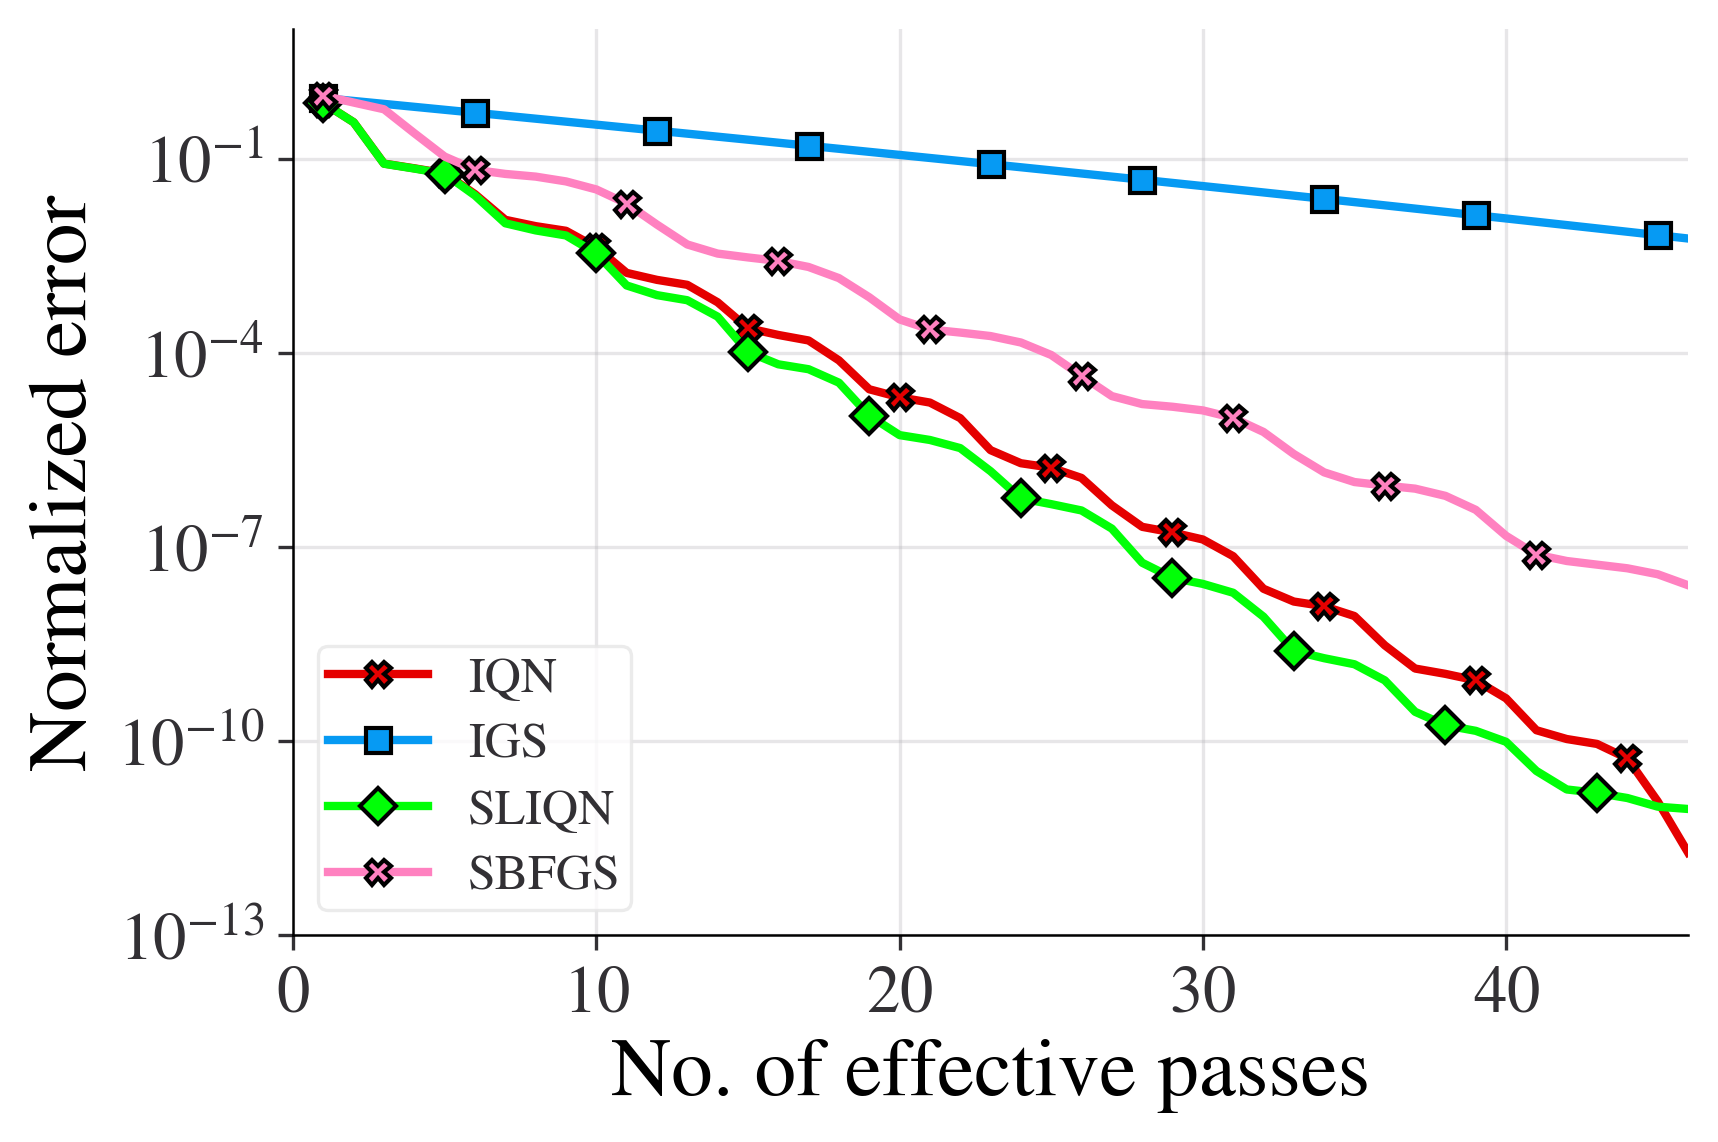

In [13]:
plt.style.use("plotstyle.txt")
plt.plot(np.arange(1, conv_iters + 1), y_axis_iqn, 'X-', label = "IQN", color='xkcd:red', markevery = 0.1)
plt.plot(np.arange(1, conv_iters + 1), y_axis_giqn, 's-', label = "IGS", color='xkcd:azure', markevery = 0.1)
plt.plot(np.arange(1, conv_iters + 1), y_axis_hiqn, 'D-', label = "SLIQN", color='xkcd:bright green', markevery = 0.1)
plt.plot(np.arange(1, conv_iters + 1), y_axis_sharpened_BFGS[0: conv_iters], 'X-', label = "SBFGS", color = 'xkcd:pink', markevery = 0.1)
plt.yscale('log')
plt.xlim([0, conv_iters])
plt.ylabel(r'Normalized error')
plt.xlabel(r'No. of effective passes')
# plt.title('Plot of Normalized error vs No of effective passes')
save_dir = "../Python_plots/synthetic" + "_N_" + str(n) + "_d_" + str(d) + "_xi_" + str(xi) + ".png"
plt.legend()
plt.savefig(save_dir)